# Разработка модели с целью определения стоимости автомобилей

# Описание проекта

Построение модели для определения стоимости автомобиля с пробегом - это сложная задача, которая требует тщательной подготовки данных, выбора правильной модели и её обучения. Следуя этим шагам, вы можете создать точную и надежную модель, которая поможет сервису по продаже б/у автомобилей привлечь новых клиентов.

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Файл `/datasets/autos.csv` содержит данные об автомобилях, выставленных на продажу**
- `DateCrawled` - дата скачивания анкеты из базы
- `VehicleType` - тип автомобильного кузова
- `RegistrationYear` - год регистрации автомобиля
- `Gearbox` - тип коробки передач
- `Power` - мощность (л. с.)
- `Model` - модель автомобиля
- `Kilometer` - пробег (км)
- `RegistrationMonth` - месяц регистрации автомобиля
- `FuelType` - тип топлива
- `Brand` - марка автомобиля
- `Repaired` - была машина в ремонте или нет
- `DateCreated` - дата создания анкеты
- `NumberOfPictures` - количество фотографий автомобиля
- `PostalCode` - почтовый индекс владельца анкеты (пользователя)
- `LastSeen` - дата последней активности пользователя
- `Price` — цена (евро)

# План работы

**Шаг 1.** Загрузить данные

**Шаг 2.** Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Неинформативные признаки удалить.

**Шаг 3.** Подготовить выборки для обучения моделей.

**Шаг 4.** Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.

**Шаг 5.** Проанализировать время обучения, время предсказания и качество моделей.

**Шаг 6.** Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

## Подготовка данных

### Импортируем необходимые библиотеки

In [1]:
!pip install -q phik
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import phik

# импортируем класс LinearRegression, класс Ridge, DecisionTreeRegressor и функцию для разделения данных и кроссвалидации
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# импортируем функции для стандартизации, кодирования 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# импортируем класс DummyRegressor
from sklearn.dummy import DummyRegressor

# импортируем функцию для RMSE
from sklearn.metrics import mean_squared_error, make_scorer

from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')

# Задаем константы
RANDOM_STATE = 12345
TEST_SIZE = 0.25

from time import time

### Загрузим данные в датафреймы pandas

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv ')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv ')

### Изучим данные

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Посмотрим на распределение целевого признака "Price"**

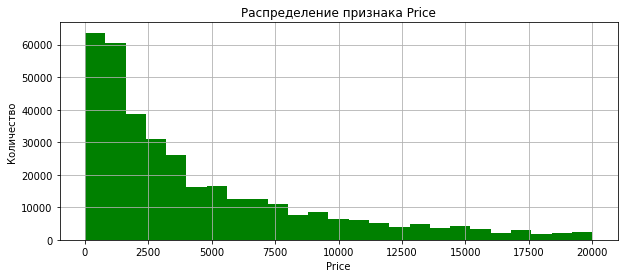

In [7]:
data['Price'].plot(kind='hist', grid=True, title= 'Распределение признака Price', bins=25, color='green', figsize=(10,4));
plt.xlabel('Price')
plt.ylabel('Количество')
plt.show()

**Посмотрим на распределение категориальных признаков "VehicleType", "Gearbox", "FuelType", "Brand", "Repaired"**

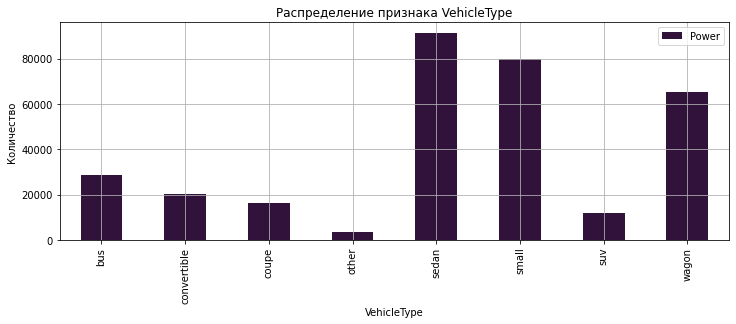

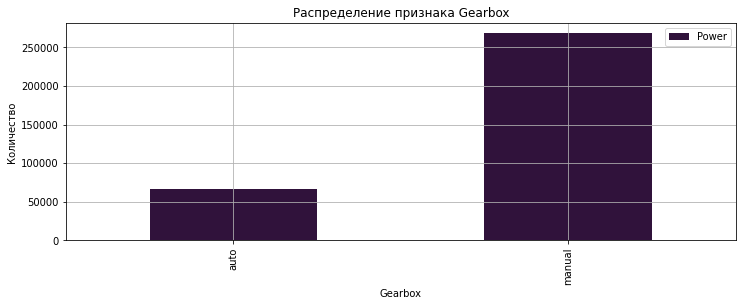

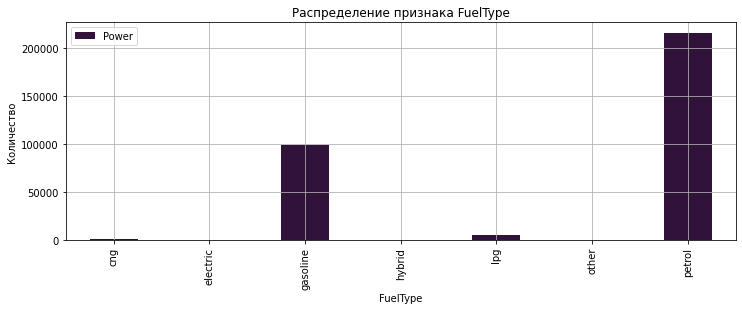

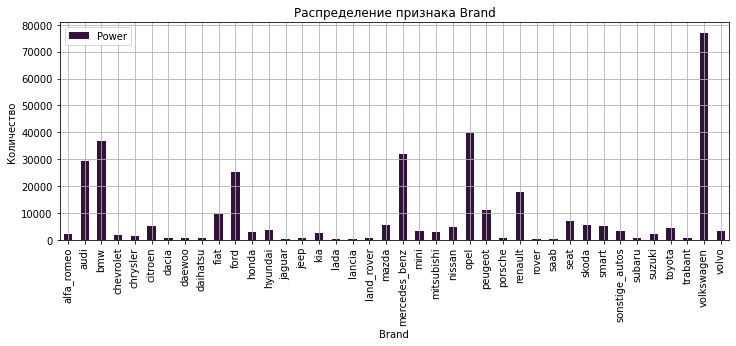

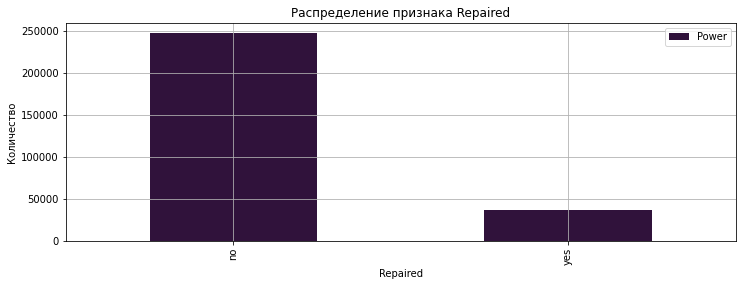

In [8]:
plt.rcParams.update({'font.size': 10})
for i in data[['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']]:
    data.pivot_table(index=i, 
                         values='Power', 
                         aggfunc='count').plot(kind='bar', 
                                               grid=True, 
                                               title= f'Распределение признака {i}', 
                                               colormap="turbo", figsize=(12,4));
    plt.ylabel('Количество')
    plt.show()

**Выводы по изучению данных:**
- В столбцах "VehicleType", "Gearbox", "Model", "FuelType", "Repaired" имеются пропуски. Их необходимо обработать.
- В столбце "Power" можно наблюдать аномальные значения как в большую так и в меньшую сторону.
- В столбцах "Price", "Power" имеются нулевые значения. Данные строки необходимо обработать.
- Столбец "NumberOfPictures" неинформативен ввиду отсутствия каких-либо значений. Данный столбец удалим.
- Столбцы "DateCrawled", "PostalCode", "LastSeen", "DateCreated" неинформативны для предсказания целевого признака "Price" (цена (евро)). Данные столбцы удалим.
- Столбец "RegistrationMonth" не информативен, ввиду наличия данных о годе регистрации автомобиля, месяц регистрации автомобиля без года бессмыслен. Удалим его.
- Данные в столбце "RegistrationYear" имеют аномальные значения. Необходимо обработать это.

### Проверим данные на наличие неявных дубликатов и ошибок в данных

In [9]:
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [10]:
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [11]:
data['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [12]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [13]:
data['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [14]:
data['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

### Проверим данные на наличие явных дубликатов

In [15]:
print('Количество явных дубликатов в датасете:', data.duplicated().sum())

Количество явных дубликатов в датасете: 4


In [16]:
data = data.drop_duplicates()

### Обработаем пропуски и аномалии

**Признак 'Price'**

Необходимо избавиться от строк в столбце "Price" с аномальными значениями ниже 300 и свыше 8000 евро.

In [17]:
data = data.query('300 < Price < 8000')

**Признак 'Power'**

Строки с нулевыми значениями и значениями свыше 1000 л.с. в столбце "Power" заменим на медианное значение в зависимости от модели машины. Также учтем машины с мощностью менее 10 л.с., их также заменим на медианное значение.

In [18]:
data.loc[(data['Power'] < 10) | (data['Power'] > 1000), 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))

In [19]:
#data.info()
data['Power'].isna().sum()

3880

In [20]:
data = data.loc[~data['Power'].isna()]

**Признак 'Gearbox'**

Заменим пропущенные значения на 'manual'

In [21]:
data.fillna({'Gearbox':'manual'}, inplace=True)

**Признак 'VehicleType'**

Заменим пропущенные значения на 'other'

In [22]:
data.fillna({'VehicleType':'other'}, inplace=True)

**Признаки 'Model', 'FuelType', 'Repaired'**

Заменим пропущенные значения на 'unknown', а в столбеце 'Repaired' заменим пропущенные занчения на 'yes', так как подержанное авто, скорее всего, хоть один раз подвергалось ремонту.

In [23]:
data.fillna({'Model':'unknown',
             'Repaired':'yes',
             'FuelType':'unknown'}, inplace=True)

**Признак 'RegistrationYear'**

Отберем года релевантные под задачу. Оставим период с 1900 и по последний год с даты выгрузки данных.

In [24]:
# Выведем последнюю дату выгрузки данных
print(pd.to_datetime(data['DateCrawled']).max())

2016-04-07 14:36:58


In [25]:
data = data.query('1900 <= RegistrationYear <= 2016')

**Удалим неинформативные столбцы**

In [26]:
data = data.drop(["NumberOfPictures", 
                   "DateCrawled", 
                   "PostalCode", 
                   "LastSeen",
                   "RegistrationMonth", 
                   "DateCreated"], axis = 1)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248130 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             248130 non-null  int64  
 1   VehicleType       248130 non-null  object 
 2   RegistrationYear  248130 non-null  int64  
 3   Gearbox           248130 non-null  object 
 4   Power             248130 non-null  float64
 5   Model             248130 non-null  object 
 6   Kilometer         248130 non-null  int64  
 7   FuelType          248130 non-null  object 
 8   Brand             248130 non-null  object 
 9   Repaired          248130 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 20.8+ MB


In [28]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,other,1993,manual,90.0,golf,150000,petrol,volkswagen,yes
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109.0,2_reihe,150000,petrol,peugeot,no


In [29]:
# Проверим еще раз данные на наличие явнях дубликатов после всех изменений
print('Количество явных дубликатов в измененном датасете:', data.duplicated().sum())

Количество явных дубликатов в измененном датасете: 37240


In [30]:
data = data.drop_duplicates()

**Выводы по предподготовке данных:**
- Избавились от дубликатов;
- Столбцы с аномальными значениями были обработаны (Избавились от строк в столбце "Price" с аномальными значениями ниже 300 и свыше 8000 евро. Строки с нулевыми значениями и значениями свыше 1000 л.с. в столбце "Power" заменили на медианное значение в зависимости от модели машины. Учли машины с мощностью менее 10 л.с., их также заменили на медианное значение. В столбце 'Gearbox' заменили пропущенные значения на 'manual'. В столбце  'VehicleType' заменили пропущенные значения на 'other'. В столбце 'RegistrationYear' отобрали года релевантные под задачу, оставили период с 1900 по 2024 гг.)
- Удалили неинформативные признаки.

### Выполним анализ корреляции датасета

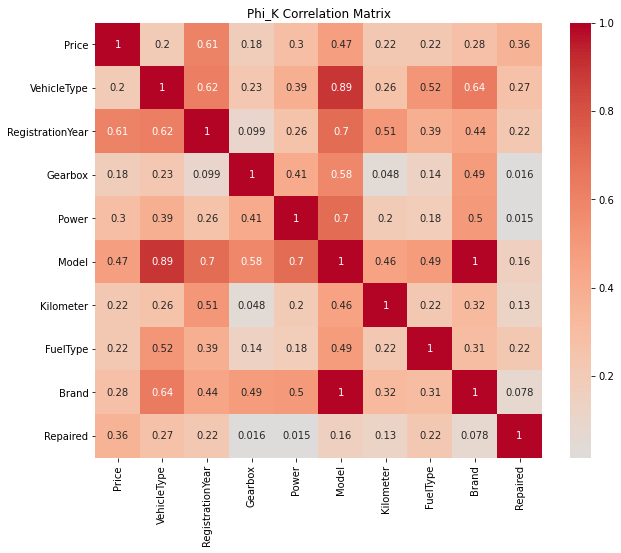

In [31]:
# Вычислим матрицу корреляции с использованием phik
corr_matrix = data.phik_matrix(interval_cols=['Price', 'Power'])

# Визуализируем матрицу корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True)
plt.title('Phi_K Correlation Matrix')
plt.show()

Можно отметить сильную прямая взаимосвязь между следующими признаками:
- `Model` и `VehicleType`;
- `Model` и `RegistrationYear`;
- `Model` и `Power`;
- `Model` и `Brand`.

## Обучение моделей

На данном этапе подготовим признаками методами кодирования и стандартизации.

Обучим следующие модели: LinearRegression, DecisionTreeRegressor, LGBMRegressor, CatBoostRegressor.

In [32]:
data.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,other,1993,manual,90.0,golf,150000,petrol,volkswagen,yes
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no


In [33]:
data.shape

(210890, 10)

### Выполним подготовку данных для дальнейшего обучения моделей

In [34]:
# Загружаем данные 
feature = data.drop('Price', axis=1)
target = data['Price']

In [35]:
# Разделим на выборки
feature_train, feature_test, target_train, target_test = train_test_split(feature, 
                                                                          target, 
                                                                          test_size = TEST_SIZE, 
                                                                          random_state = RANDOM_STATE)

In [36]:
for i in [feature_train, feature_test, target_train, target_test]:
    print(i.shape)  

(158167, 9)
(52723, 9)
(158167,)
(52723,)


In [37]:
# Закодируем признаки с помощью OneHotEncoder
cat_col_names = ['VehicleType', 'Model', 'FuelType', 'Brand', 'Gearbox', 'Repaired']
# Создадим переменную с классом кодирования, включим параметр для избегания дамми-ошибок
encoder1 = OneHotEncoder(drop='first', sparse=False)
feature_train_ohe = encoder1.fit_transform(feature_train[cat_col_names])
# Преобразуем категориальные признаки в тренировочной выборке
feature_test_ohe = encoder1.transform(feature_test[cat_col_names])

In [38]:
# Выведем список новых столбцов после кодирования
encoder_col_names = encoder1.get_feature_names()

feature_train_ohe = pd.DataFrame(feature_train_ohe, columns=encoder_col_names)
feature_test_ohe = pd.DataFrame(feature_test_ohe, columns=encoder_col_names)

In [39]:
# Закодируем признаки с помощью OrdinalEncoder
encoder2 = OrdinalEncoder(handle_unknown='ignore')
columns_oe = ['VehicleType', 'Model', 'FuelType', 'Brand', 'Gearbox', 'Repaired']
# Кодирование для тренировочных данных
oe_feature_train = encoder2.fit_transform(feature_train[columns_oe])
# Кодирование для тестовых данных
oe_feature_test = encoder2.transform(feature_test[columns_oe])

In [40]:
# Выведем список новых столбцов после кодирования с помощью OrdinalEncoder
oe_feature_train = pd.DataFrame(oe_feature_train, columns=columns_oe)
oe_feature_test = pd.DataFrame(oe_feature_test, columns=columns_oe)

In [41]:
scaler = StandardScaler()
num_col_names = ['RegistrationYear', 'Power', 'Kilometer']
# Обучим и преобразуем количественные признаки в тренировочной выборке
scaler_feature_train = scaler.fit_transform(feature_train[num_col_names])
# Преобразуем количественные признаки в тестовой выборке
scaler_feature_test = scaler.transform(feature_test[num_col_names])

In [42]:
# Выведем список новых столбцов после стандартизации
scaler_feature_train = pd.DataFrame(scaler_feature_train, columns=num_col_names)
scaler_feature_test = pd.DataFrame(scaler_feature_test, columns=num_col_names)

In [43]:
# Объединим полученные закодированные данные с помощью  OneHotEncoder и стандартизованные данные

OHE_feature_train = pd.concat([feature_train_ohe, feature_train[num_col_names].sort_index().reset_index(drop=True)], axis=1)
OHE_feature_test = pd.concat([feature_test_ohe, feature_test[num_col_names].sort_index().reset_index(drop=True)], axis=1)

In [45]:
# Объединим полученные закодированные данные с помощью  OrdinalEncoder и стандартизованные данные

OE_feature_train = pd.concat([oe_feature_train, scaler_feature_train], axis=1)
OE_feature_test = pd.concat([oe_feature_test, scaler_feature_test], axis=1)

### Обучение модели LinearRegression

In [46]:
scoring_metrics = make_scorer(mean_squared_error, 
                              greater_is_better=False,
                              squared=False)

In [47]:
start = time()

LR_model = LinearRegression()
cv_RMSE_LR = (cross_val_score(LR_model,
                           OHE_feature_train,
                           target_train,
                           cv = 5,
                           scoring = scoring_metrics)).mean()*-1
           
print('RMSE на модели LinearRegression =', cv_RMSE_LR)

end = time()
LR_model_time = (end-start)
print(round(LR_model_time,3),'сек')

RMSE на модели LinearRegression = 1760.985341068263
50.713 сек


In [48]:
start = time()
LR_model.fit(OHE_feature_train, target_train)
end = time()
LR_time = (end-start)
print('Время обучения модели LinearRegression', round(LR_time,3),'сек')

Время обучения модели LinearRegression 11.699 сек


In [49]:
start = time()
LR_predict = LR_model.predict(OHE_feature_train)
end = time()
LR_predict = (end-start)
print('Время предсказания модели LinearRegression', round(LR_predict,3),'сек')

Время предсказания модели LinearRegression 0.311 сек


### Обучение модели DecisionTreeRegressor

In [50]:
start = time()

DTR_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
params = [{'criterion':['friedman_mse', 'poisson'],
           'max_depth': (None, *range(2, 25))}]

clf = GridSearchCV(DTR_model, params, scoring = scoring_metrics)
clf.fit(OE_feature_train, target_train)

print('Лучшие параметры модели DecisionTreeRegressor:\n\n', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
par = clf.cv_results_['params']
    
cv_RMSE_DTR = (max(means)*-1) 
print('RMSE для лучшей модели DecisionTreeRegressor на CV:', cv_RMSE_DTR)

end = time()
DTR_model_time = (end-start)
print(round(DTR_model_time,3),'сек')

Лучшие параметры модели DecisionTreeRegressor:

 {'criterion': 'friedman_mse', 'max_depth': 13}
RMSE для лучшей модели DecisionTreeRegressor на CV: 1148.904387774491
67.453 сек


In [51]:
start = time()
DTR_model = DecisionTreeRegressor(criterion = 'friedman_mse', 
                                  max_depth = 13,
                                  random_state = RANDOM_STATE)
DTR_model.fit(OE_feature_train, target_train)
end = time()
DTR_time = (end-start)
print('Время обучения модели DecisionTreeRegressor', round(DTR_time,3),'сек')

Время обучения модели DecisionTreeRegressor 0.342 сек


In [52]:
start = time()
DTR_predict = DTR_model.predict(OE_feature_train)
end = time()
DTR_predict = (end-start)
print('Время предсказания модели DecisionTreeRegressor', round(DTR_predict,3),'сек')

Время предсказания модели DecisionTreeRegressor 0.022 сек


### Обучение модели LGBMRegressor

In [53]:
start = time()

LGBMR_model = LGBMRegressor(random_state=RANDOM_STATE)
params = [{'num_leaves':[25, 50, 75], 
           'learning_rate':[0.1, 0.3]}]

clf = GridSearchCV(LGBMR_model, params, scoring = scoring_metrics)
clf.fit(OE_feature_train, target_train)

print('Лучшие параметры модели LGBMRegressor:\n\n', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
par = clf.cv_results_['params']

cv_RMSE_LGBMR = (max(means)*-1) 
print('RMSE для лучшей модели LGBMRegressor на CV:', cv_RMSE_LGBMR)

end = time()
LGBMR_model_time = (end-start)
print(round(LGBMR_model_time,3),'сек')

Лучшие параметры модели LGBMRegressor:

 {'learning_rate': 0.3, 'num_leaves': 75}
RMSE для лучшей модели LGBMRegressor на CV: 996.4799080459118
137.895 сек


In [54]:
start = time()
LGBMR_model = LGBMRegressor(learning_rate = 0.3, 
                            num_leaves = 75,
                            random_state = RANDOM_STATE)
LGBMR_model.fit(OE_feature_train, target_train)
end = time()
LGBMR_time = (end-start)
print('Время обучения модели LGBMRegressor', round(LGBMR_time,3),'сек')

Время обучения модели LGBMRegressor 4.894 сек


In [55]:
start = time()
LGBMR_predict = LGBMR_model.predict(OE_feature_train)
end = time()
LGBMR_predict = (end-start)
print('Время предсказания модели LGBMRegressor', round(LGBMR_predict,3),'сек')

Время предсказания модели LGBMRegressor 1.001 сек


### Обучение модели CatBoostRegressor

In [56]:
start = time()

CBR_model = CatBoostRegressor(random_state=RANDOM_STATE)
params = [{'learning_rate':[0.1, 0.3, 0.5, 0.7],
           'verbose':[False]}]

clf = GridSearchCV(CBR_model, params, scoring = scoring_metrics)
clf.fit(OE_feature_train, target_train)

print('Лучшие параметры модели CatBoostRegressor:\n\n', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
par = clf.cv_results_['params']

cv_RMSE_CBR = (max(means)*-1) 
print('RMSE для лучшей модели CatBoostRegressor на CV:', cv_RMSE_CBR)

end = time()
CBR_model_time = (end-start)
print(round(CBR_model_time,3),'сек')

Лучшие параметры модели CatBoostRegressor:

 {'learning_rate': 0.3, 'verbose': False}
RMSE для лучшей модели CatBoostRegressor на CV: 987.3287133096577
313.155 сек


In [57]:
start = time()
CBR_model = CatBoostRegressor(learning_rate = 0.3, 
                              verbose = False,
                              random_state = RANDOM_STATE)
CBR_model.fit(OE_feature_train, target_train)
end = time()
CBR_time = (end-start)
print('Время обучения модели CatBoostRegressor', round(CBR_time,3),'сек')

Время обучения модели CatBoostRegressor 17.796 сек


In [58]:
start = time()
CBR_predict = CBR_model.predict(OE_feature_train)
end = time()
CBR_predict = (end-start)
print('Время предсказания модели CatBoostRegressor', round(CBR_predict,3),'сек')

Время предсказания модели CatBoostRegressor 0.146 сек


### Выводы по обучению моделей:
- Выполнено кодирование и стандартизация данных;
- Обучили следующие модели: 
      - LinearRegression
      - DecisionTreeRegressor
      - LGBMRegressor
      - CatBoostRegressor
- Зафиксировали лучшие гиперпараметры моделей;
- Зафиксировали время выполнения обучений и предсказания моделей.

## Анализ моделей

Выведем время выполнения обучений моделей и метрику RMSE на тестовых данных

In [59]:
# Создадим сводную таблицу с результатами получившихся моделей
model = ['LinearRegression',
         'DecisionTreeRegressor',
         'LGBMRegressor',
         'CatBoostRegressor'] 
RMSE_time = {'RMSE для лучшей модели на CV':[cv_RMSE_LR,
                                             cv_RMSE_DTR,
                                             cv_RMSE_LGBMR,
                                             cv_RMSE_CBR],
             'Время обучения модели, сек': [LR_time,
                                            DTR_time,
                                            LGBMR_time,
                                            CBR_time],
             'Время предсказания модели, сек': [LR_predict,
                                                DTR_predict,
                                                LGBMR_predict,
                                                CBR_predict]}
df = pd.DataFrame(RMSE_time, index = model)

# Добавим рейтинг моделей в зависимости от значений RMSE и времени обучения и предсказания
df['Рейтинг моделей'] = ((df['RMSE для лучшей модели на CV'].min()/df['RMSE для лучшей модели на CV']) +
                         (df['Время обучения модели, сек'].min()/df['Время обучения модели, сек']) +
                         (df['Время предсказания модели, сек'].min()/df['Время предсказания модели, сек']))

display(df.sort_values(['Рейтинг моделей'], ascending = False))

,RMSE для лучшей модели на CV,"Время обучения модели, сек","Время предсказания модели, сек",Рейтинг моделей
DecisionTreeRegressor,1148.904388,0.341763,0.021637,2.859365
CatBoostRegressor,987.328713,17.796366,0.145510,1.167902
LGBMRegressor,996.479908,4.894097,1.000504,1.082274
LinearRegression,1760.985341,11.698690,0.310886,0.659480


### Сравнение получившихся метрик моделей и время обучения моделей

**Выводы по анализу моделей:**

- По сводной таблице по рейтингу лидирует модель DecisionTreeRegressor с оптимальным временем обучения модели и предсказания, а также значением RMSE.

- По анализу значений метрики RMSE, лидируют модели CatBoostRegressor, LGBMRegressor. В то время, как модели LinearRegression показывают наихудший результат. 

- Стоит отметить модель LGBMRegressor, показатель метркии один из самых лучших, показатель по времени обучения не самый высокий. Если не акцентировать основное внимание на время, то данная модель хороша для точности предсказания.

### RMSE на тестовых данных лучшей модели DecisionTreeRegressor

In [60]:
%%time
DTR_model = DecisionTreeRegressor(criterion = 'friedman_mse', 
                                  max_depth = 13,
                                  random_state = RANDOM_STATE)
DTR_model.fit(OE_feature_train, target_train)

CPU times: user 294 ms, sys: 531 µs, total: 295 ms
Wall time: 294 ms


DecisionTreeRegressor(criterion='friedman_mse', max_depth=13,
                      random_state=12345)

In [61]:
%%time
DTR_predict = DTR_model.predict(OE_feature_test)
DTR_RMSE_test = mean_squared_error(target_test, DTR_predict)**0.5
print(round(DTR_RMSE_test, 3))

1135.449
CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 10.1 ms


Лучшая модель DecisionTreeRegressor на тестовых данных показала следующие результаты:
- метрика RMSE - 1135.449
- время обучения - 0,294 сек.
- время предсказания - 0,010 сек.

### Проверим лучшую модель на адекватность

In [62]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(OE_feature_train, target_train)
pred_reg = dummy_regr.predict(OE_feature_test)
print(f'Метрика SMAPE модели DummyRegressor: {mean_squared_error(target_test, pred_reg)**0.5}')

Метрика SMAPE модели DummyRegressor: 2088.811470841037


Результат тестирования нашей модели на тествой выборке лучше, чем результат константной модели, что подтверждает адекватность лучшей модели.

# Общий вывод

**Выводы по изучению данных:**

- В столбцах "VehicleType", "Gearbox", "Model", "FuelType", "Repaired" имеются пропуски. Их необходимо обработать.
- В столбце "Power" можно наблюдать аномальные значения как в большую так и в меньшую сторону.
- В столбцах "Price", "Power" имеются нулевые значения. Данные строки необходимо обработать.
- Столбец "NumberOfPictures" неинформативен ввиду отсутствия каких-либо значений. Данный столбец удалим.
- Столбцы "DateCrawled", "PostalCode", "LastSeen", "DateCreated" неинформативны для предсказания целевого признака "Price" (цена (евро)). Данные столбцы удалим.
- Столбец "RegistrationMonth" не информативен, ввиду наличия данных о годе регистрации автомобиля, месяц регистрации автомобиля без года бессмыслен. Удалим его.
- Данные в столбце "RegistrationYear" имеют аномальные значения. Необходимо обработать это.

**Выводы по предобработке данных:**
- Избавились от дубликатов;
- Столбцы с аномальными значениями были обработаны (Избавились от строк в столбце "Price" с аномальными значениями ниже 300 и свыше 8000 евро. Строки с нулевыми значениями и значениями свыше 1000 л.с. в столбце "Power" заменили на медианное значение в зависимости от модели машины. Учли машины с мощностью менее 10 л.с., их также заменили на медианное значение. В столбце 'Gearbox' заменили пропущенные значения на 'manual'. В столбце  'VehicleType' заменили пропущенные значения на 'other'. В столбце 'RegistrationYear' отобрали года релевантные под задачу, оставили период с 1900 по 2016 гг.)
- Удалили неинформативные признаки.

**Выводы по обучению моделей:**
- Выполнено кодирование и стандартизация данных;
- Обучили следующие модели: 
      - LinearRegression
      - DecisionTreeRegressor
      - LGBMRegressor
      - CatBoostRegressor
- Зафиксировали лучшие гиперпараметры моделей;
- Зафиксировали время выполнения обучений и предсказания моделей.


**Выводы по анализу моделей:**
- По сводной таблице по рейтингу лидирует модель DecisionTreeRegressor с оптимальным временем обучения модели и предсказания, а также значением RMSE.

- По анализу значений метрики RMSE, лидируют модели CatBoostRegressor, LGBMRegressor. В то время, как модели LinearRegression показывают наихудший результат. 

- Стоит отметить модель LGBMRegressor, показатель метркии один из самых лучших, показатель по времени обучения не самый высокий. Если не акцентировать основное внимание на время, то данная модель хороша для точности предсказания.

**Выводы по лучшей модели**

Лучшая модель DecisionTreeRegressor на тестовых данных показала следующие результаты:
- метрика RMSE - 1135.449
- время обучения - 0,294 сек.
- время предсказания - 0,010 сек.